# モンテカルロ法の考え方を迷路問題を用いて確認する

In [1]:
import numpy as np
from collections import defaultdict
from common.agent import CommonAgent
from common.show_value import show_q_value
from common.meiro import Environment

### [参考]

In [2]:
# defaultdictを使うと、valueの形を自動的につくってくれる
dic = defaultdict(lambda: [0] * 4) # valueのデフォルトが「要素数4で値が0のリスト」になる
dic["a"][2] = 111
dic["b"][3] = 555
dic["c"][1] = 222
print(dic)

defaultdict(<function <lambda> at 0x119933e18>, {'a': [0, 0, 111, 0], 'b': [0, 0, 0, 555], 'c': [0, 222, 0, 0]})


In [3]:
class MonteCarloAgent(CommonAgent):
    """
    モンテカルロ法のエージェントクラス
    """

    def __init__(self, epsilon=0.1):
        """
        epsilon : float, 探索する確率
        """
        # CommonAgentクラスの__init__メソッドを実行する
        super().__init__(epsilon)
    
    def policy(self, s, actions):
        """
        方策関数(epsilon-greedy法)
        """
        if np.random.random() < self.epsilon:
            """
            探索
            """
            return np.random.choice(actions)
        else:
            """
            利用
            """
            if s in self.Q and sum(self.Q[s]) != 0:
                # 行動価値Qが最大になる行動aのインデックスを返す
                return np.argmax(self.Q[s])
            else:
                """
                例外処理
                """
                return np.random.choice(actions)
            
    def learn(self, env, episode_num=1000, gamma=0.9, report_interval=50, alpha=0.01):
        """
        学習を実行するメソッド
        episode_num : エピソード数
        gamma : 割引率
        report_interval : 結果を表示させる間隔
        alpha : 学習率
        """
        # 初期化
        self.init_log()
        actions = env.actions # 行動の種類
        num_actions = len(actions)
        self.Q = defaultdict(lambda: [0] * num_actions) # 行動価値

        # エピソードのループ
        for e in range(episode_num):
            
            # 初期化
            s = env.reset()
            done = False
            
            # 1エピソードを実行
            experience = []
            while not done:
                # 現在の方策に基づいて、行動をとる
                a = self.policy(s, actions)
                next_state, reward, done = env.step(a)
                
                # 結果(経験)を記録する
                experience.append({"state": s, "action": a, "reward": reward})
                
                # 状態を更新する
                s = next_state
            
            # 最後の報酬を記録しておく
            self.log(reward)
            
            # 行動価値Qを更新する
            for i, x in enumerate(experience):
                s, a = x["state"], x["action"]

                # 期待割引収益を算出する
                G, t = 0, 0
                for j in range(i, len(experience)):
                    G += np.power(gamma, t) * experience[j]["reward"]
                    t += 1
                
                # 期待割引収益Gを用いて行動価値Qを更新
                self.Q[s][a] = (1 - alpha)*self.Q[s][a] + alpha * G # Gの移動平均をQに代入する
                # ここで移動平均を用いているのは、まだ十分に探索していない状態の方策で経験したことは信頼できないので
                # より直近の信頼できるGを利用して行動価値を推定したいためである。
                # また、ここでは、s,aのすべての収益を用いるため、逐一訪問モンテカルロ法で計算していることになる。
                # ここを、s,aの初回の収益だけを用いるようにすれば、初回訪問モンテカルロ法となる。

            # 報酬を表示する
            if e != 0 and e % report_interval == 0:
                self.show_rewards_log(episode=e)


## 実行

In [4]:
# 迷路の条件を設定する
grid = np.array([[0,0,0,0],[0,-1,0,-1],[0,0,0,-1],[-1,0,0,1]])

# 環境をつくる
env = Environment(grid, move_prob=0.95, agent_init_state=(0,0))
# モンテカルロ法において、初期位置は可能な候補の中からランダムに選ぶべきですが、
# 迷路問題の場合、初期値は問題設定として与えられているため、可能な候補は1点のみになる。
# よって、ランダムに選ぶことができない。固定された初期値から始めたとしても行動は
# 確率的に選択されるため、全ての状態行動対が無限回訪問されることを仮定できる。

# エージェントをつくる
agent = MonteCarloAgent(epsilon=0.1)

# 学習の実行
agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)


At Episode 50 average reward is -0.56 (+/-0.828).
At Episode 100 average reward is 0.32 (+/-0.947).
At Episode 150 average reward is 0.56 (+/-0.828).
At Episode 200 average reward is 0.44 (+/-0.898).
At Episode 250 average reward is 0.36 (+/-0.933).
At Episode 300 average reward is 0.8 (+/-0.6).
At Episode 350 average reward is 0.68 (+/-0.733).
At Episode 400 average reward is 0.76 (+/-0.65).
At Episode 450 average reward is 0.64 (+/-0.768).


## 結果の可視化

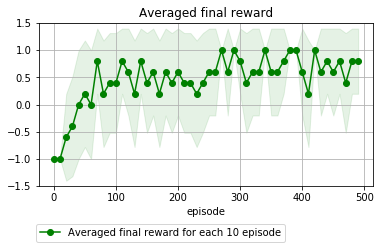

In [5]:
# agent.rewards_logに保存している各エピソードの最終報酬額を可視化する
# 全エピソードを表示させると傾向を捉えにくくなるため、10エピソード毎に平均をとっている
# 学習が進むと、エージェントはゴールできるようになってくるため、値は1(ゴール時の報酬)に近づく
# 薄い緑の領域は、10エピソード分の値の標準偏差(=1)を意味する
agent.show_rewards_log(interval=10)

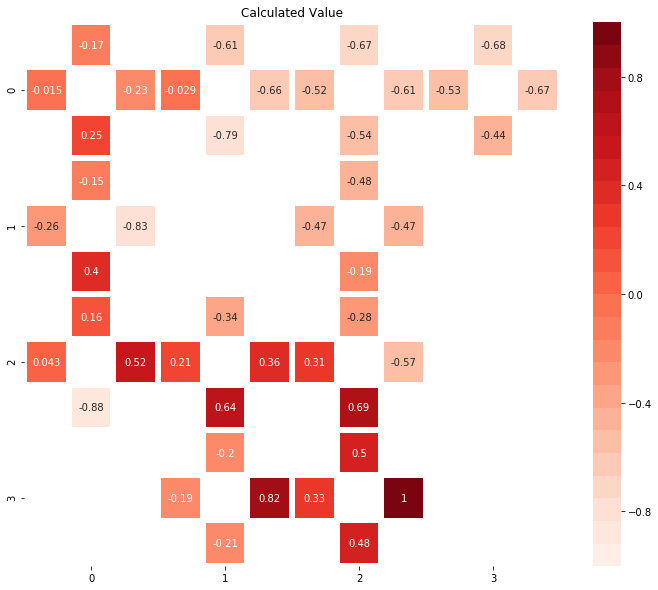

In [6]:
# 学習によって求めた行動価値Qを可視化する
# 行動価値は、通常セル毎に4つの値(UP,DOEN,LEFT,RIGTH)を持っている
# 以下のグラフでは、通常セルを中心に、上下左右の4つのセルに値を配置した
show_q_value(agent.Q, row=grid.shape[0], col=grid.shape[1])    

### [演習]
* grid条件、エージェントの初期位置、epsilon、alphaなどを変更して、学習の進み具合を確認しましょう